<a href="https://colab.research.google.com/github/luliu84/DS-Capstone/blob/master/Data_Science_Capstone_Collision_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Data Science Capstone Week 2 
## A description of the problem and a discussion of the background
## A description of the data and how it will be used to solve the problem

# Import Library and Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import chi2_contingency

In [ ]:
# Retrive the dataset
from google.colab import files
uploaded = files.upload()

Saving Data_Collisions.csv to Data_Collisions.csv


In [ ]:
dc = pd.read_csv(r'Data_Collisions.csv')

In [ ]:
print(dc.shape)
print(list(dc.columns))

(221738, 40)
['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [ ]:

dc.head(5)

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.356511,47.517361,1,327920,329420,3856094,Matched,Intersection,34911.0,17TH AVE SW AND SW ROXBURY ST,,NaN,1,Property Damage Only Collision,Angles,2,0,0,2,0,0,0,2020/01/19 00:00:00+00,1/19/2020 9:01:00 AM,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,-122.361405,47.702064,2,46200,46200,1791736,Matched,Block,NaN,HOLMAN RD NW BETWEEN 4TH AVE NW AND 3RD AVE NW,NaN,NaN,1,Property Damage Only Collision,Rear Ended,2,0,0,2,0,0,0,2005/04/11 00:00:00+00,4/11/2005 6:31:00 PM,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",Y,0,Raining,Wet,Dusk,NaN,5101020.0,NaN,13,From same direction - both going straight - bo...,0,0,N
2,-122.317414,47.664028,3,1212,1212,3507861,Matched,Block,NaN,ROOSEVELT WAY NE BETWEEN NE 47TH ST AND NE 50T...,,NaN,2,Injury Collision,Head On,2,0,0,2,1,0,0,2013/03/31 00:00:00+00,3/31/2013 2:09:00 AM,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Dark - Street Lights On,NaN,NaN,NaN,30,From opposite direction - all others,0,0,N
3,-122.318234,47.619927,4,327909,329409,EA03026,Matched,Intersection,29054.0,11TH AVE E AND E JOHN ST,,NaN,2,Injury Collision,Pedestrian,3,1,0,1,1,0,0,2020/01/06 00:00:00+00,1/6/2020 5:55:00 PM,At Intersection (intersection related),24.0,MOTOR VEHCILE STRUCK PEDESTRIAN,NaN,N,Raining,Wet,Dark - Street Lights On,NaN,NaN,NaN,0,Vehicle going straight hits pedestrian,0,0,N
4,-122.351724,47.560306,5,104900,104900,2671936,Matched,Block,NaN,WEST MARGINAL WAY SW BETWEEN SW ALASKA ST AND ...,NaN,NaN,2,Injury Collision,Other,2,0,0,1,1,0,0,2009/12/25 00:00:00+00,12/25/2009 7:00:00 PM,Mid-Block (not related to intersection),28.0,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,0,Clear,Ice,Dark - Street Lights On,NaN,9359012.0,Y,50,Fixed object,0,0,N


In [ ]:
dc.isna().sum()
#dc.isnull().sum() -- same results as isna()


X                    7478
Y                    7478
OBJECTID                0
INCKEY                  0
COLDETKEY               0
REPORTNO                0
STATUS                  0
ADDRTYPE             3714
INTKEY             149711
LOCATION             4593
EXCEPTRSNCODE      120403
EXCEPTRSNDESC      209953
SEVERITYCODE            1
SEVERITYDESC            0
COLLISIONTYPE       26451
PERSONCOUNT             0
PEDCOUNT                0
PEDCYLCOUNT             0
VEHCOUNT                0
INJURIES                0
SERIOUSINJURIES         0
FATALITIES              0
INCDATE                 0
INCDTTM                 0
JUNCTIONTYPE        11979
SDOT_COLCODE            1
SDOT_COLDESC            1
INATTENTIONIND     191550
UNDERINFL           26431
WEATHER             26641
ROADCOND            26560
LIGHTCOND           26730
PEDROWNOTGRNT      216543
SDOTCOLNUM          94533
SPEEDING           211802
ST_COLCODE           9413
ST_COLDESC          26451
SEGLANEKEY              0
CROSSWALKKEY

# Target Variable Clean and Setup




In [ ]:
dc.groupby("SEVERITYCODE")["SEVERITYCODE"].count()  #count does not include null.

SEVERITYCODE
0      21656
1     137776
2      58842
2b      3111
3        352
Name: SEVERITYCODE, dtype: int64

In [ ]:
dc.groupby(["SEVERITYCODE",'SEVERITYDESC'])["SEVERITYCODE"].count() 
# why is dtype: int64?  It is a text field

SEVERITYCODE  SEVERITYDESC                  
0             Unknown                            21656
1             Property Damage Only Collision    137776
2             Injury Collision                   58842
2b            Serious Injury Collision            3111
3             Fatality Collision                   352
Name: SEVERITYCODE, dtype: int64

In [ ]:
dc[dc['SEVERITYCODE'].isnull()] 

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
195398,-122.327646,47.630597,195399,270579,271399,3753394,Matched,Intersection,29084.0,EASTLAKE AVE E AND E NELSON PL,,NaN,NaN,Unknown,NaN,2,0,1,1,0,0,0,2018/02/14 00:00:00+00,2/14/2018 7:50:00 AM,At Intersection (intersection related),18.0,"MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END A...",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,NaN,NaN,0,0,N


Fill the SEVERITYCODE is null record with value of 0 as SEVERITYDESC is UNKNOWN

In [ ]:
# need to use '0' instead of 0 for string.  Otherwise, the freq of SEVERITYCODE
# shows two rows for 0 (one for the text value, the other for the numeric value)

dc['SEVERITYCODE'].fillna('0',inplace=True) 

In [ ]:
dc.groupby(["SEVERITYCODE"])["SEVERITYCODE"].count() 
#dc.groupby(["SEVERITYCODE"]).count() 

SEVERITYCODE
0      21657
1     137776
2      58842
2b      3111
3        352
Name: SEVERITYCODE, dtype: int64

Drop ROWS with SEVERITYCODE = 0

In [ ]:
dc.drop(dc[dc['SEVERITYCODE']=='0'].index, inplace=True)

In [ ]:
dc.groupby(["SEVERITYCODE"])["SEVERITYCODE"].count() 
#rows have been dropped

SEVERITYCODE
1     137776
2      58842
2b      3111
3        352
Name: SEVERITYCODE, dtype: int64

In [ ]:
print(dc.shape)

(200081, 40)


Create a new variable SEVERITY_NEW (1 = Fatal, 0 = Non-Fatal)

In [ ]:
dc['SEVERITYCODE']=np.where(dc['SEVERITYCODE']=='1',0, dc['SEVERITYCODE'])
dc['SEVERITYCODE']=np.where(dc['SEVERITYCODE']=='2',0, dc['SEVERITYCODE'])
dc['SEVERITYCODE']=np.where(dc['SEVERITYCODE']=='2b',1, dc['SEVERITYCODE'])
dc['SEVERITYCODE']=np.where(dc['SEVERITYCODE']=='3',1, dc['SEVERITYCODE'])

#question - didn't quite work if assign to a new column.

In [ ]:
dc.groupby([dc['SEVERITYCODE']=='3'])['SEVERITYCODE'].count()

SEVERITYCODE
False    200081
Name: SEVERITYCODE, dtype: int64

In [ ]:
dc.groupby("SEVERITYCODE")["SEVERITYCODE"].count()

SEVERITYCODE
0    196618
1      3463
Name: SEVERITYCODE, dtype: int64

In [ ]:
(dc["SEVERITYCODE"].isnull()==True).sum()

0

# Predictors

Keep 7 predictors that look relevant and have data

In [ ]:
dc2=dc[['SEVERITYCODE','ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND']]
dc2.shape
dc2.head(20)



,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND
0,0,Intersection,Angles,At Intersection (intersection related),N,Clear,Dry,Daylight
1,0,Block,Rear Ended,Mid-Block (not related to intersection),0,Raining,Wet,Dusk
2,0,Block,Head On,Mid-Block (not related to intersection),N,Clear,Dry,Dark - Street Lights On
3,0,Intersection,Pedestrian,At Intersection (intersection related),N,Raining,Wet,Dark - Street Lights On
4,0,Block,Other,Mid-Block (not related to intersection),0,Clear,Ice,Dark - Street Lights On
5,0,Block,Rear Ended,Mid-Block (not related to intersection),N,Clear,Dry,Daylight
6,0,Block,Cycles,Mid-Block (not related to intersection),N,Overcast,Dry,Daylight
7,0,NaN,Parked Car,Mid-Block (not related to intersection),0,Clear,Dry,Daylight
8,1,Block,Rear Ended,Mid-Block (not related to intersection),0,Clear,Dry,Daylight
9,0,Block,Rear Ended,Mid-Block (but intersection related),0,Clear,Wet,Dusk


In [ ]:
# make a copy of dc2
dc2_copy=dc2
dc2_copy.head()

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND
0,0,Intersection,Angles,At Intersection (intersection related),N,Clear,Dry,Daylight
1,0,Block,Rear Ended,Mid-Block (not related to intersection),0,Raining,Wet,Dusk
2,0,Block,Head On,Mid-Block (not related to intersection),N,Clear,Dry,Dark - Street Lights On
3,0,Intersection,Pedestrian,At Intersection (intersection related),N,Raining,Wet,Dark - Street Lights On
4,0,Block,Other,Mid-Block (not related to intersection),0,Clear,Ice,Dark - Street Lights On


##Data Exploration 1

Count cells and rows with missing value

In [ ]:
# cells with missing value
dc2.isnull().values.ravel().sum()
#np.count_nonzero(dc2.isnull()) 

32857

In [ ]:
# row with missing value - results - every row has missing value
dc2.isna().any(axis = 1).sum()
# sum(dc.isnull().values.any(axis=1))

11754

In [ ]:
# missing value count for a specified column
#(dc2["ADDRTYPE"].isnull()==True).sum()

# missing value count for a column
dc2.isnull().sum()

SEVERITYCODE        0
ADDRTYPE         1933
COLLISIONTYPE    4796
JUNCTIONTYPE     6383
UNDERINFL        4776
WEATHER          4987
ROADCOND         4906
LIGHTCOND        5076
dtype: int64

### Variable 1 - 'ADDRTYPE'

In [ ]:
# Frequency by value
#(dc2["ROADCOND"].isnull()==True).sum()
#dc2.groupby("ADDRTYPE")["ADDRTYPE"].count()
dc2.groupby(["SEVERITYCODE","ADDRTYPE"])["SEVERITYCODE"].count()

SEVERITYCODE  ADDRTYPE    
0             Alley              759
              Block           128127
              Intersection     65802
1             Alley                5
              Block             1725
              Intersection      1730
Name: SEVERITYCODE, dtype: int64

In [ ]:
# missing value count GROUP BY SEVERITYCODE
dc2.groupby(['SEVERITYCODE'])['ADDRTYPE'].apply(lambda x: x.isnull().sum())

SEVERITYCODE
0    1930
1       3
Name: ADDRTYPE, dtype: int64

In [ ]:
# assign "other" to cells with missing value

dc2.loc[dc2['ADDRTYPE'].isnull()==False, 'ADDRTYPE_NEW'] = dc2['ADDRTYPE']
dc2.loc[dc2['ADDRTYPE'].isnull()== True, 'ADDRTYPE_NEW'] = 'Unknown' 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

In [ ]:
(dc2["ADDRTYPE_NEW"].isnull()==True).sum()

0

In [ ]:
dc2.groupby(["SEVERITYCODE","ADDRTYPE_NEW"])["SEVERITYCODE"].count()

SEVERITYCODE  ADDRTYPE_NEW
0             Alley              759
              Block           128127
              Intersection     65802
              Unknown           1930
1             Alley                5
              Block             1725
              Intersection      1730
              Unknown              3
Name: SEVERITYCODE, dtype: int64

### Variable 2 - 'COLLISIONTYPE' (not going to use)

In [ ]:
#dc2.groupby("INATTENTIONIND")["INATTENTIONIND"].count()
dc2.groupby(["SEVERITYCODE","COLLISIONTYPE"])["SEVERITYCODE"].count()

SEVERITYCODE  COLLISIONTYPE
0             Angles           35117
              Cycles            5485
              Head On           2060
              Left Turn        13830
              Other            23996
              Parked Car       48423
              Pedestrian        6685
              Rear Ended       34470
              Right Turn        2995
              Sideswipe        18819
1             Angles             471
              Cycles             451
              Head On            129
              Left Turn          291
              Other              605
              Parked Car         135
              Pedestrian         983
              Rear Ended         236
              Right Turn          23
              Sideswipe           81
Name: SEVERITYCODE, dtype: int64

In [ ]:
dc2.groupby(['SEVERITYCODE'])['COLLISIONTYPE'].apply(lambda x: x.isnull().sum())

SEVERITYCODE
0    4738
1      58
Name: COLLISIONTYPE, dtype: int64

In [ ]:
dc2.COLLISIONTYPE.replace(np.NaN,'Other', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
dc2.groupby(['SEVERITYCODE'])['COLLISIONTYPE'].apply(lambda x: x.isnull().sum())

SEVERITYCODE
0    0
1    0
Name: COLLISIONTYPE, dtype: int64

### Variable 3 - 'UNDERINFL'

In [ ]:
#dc2.groupby("UNDERINFL")["UNDERINFL"].count()
dc2.groupby(["SEVERITYCODE","UNDERINFL"])["SEVERITYCODE"].count()

SEVERITYCODE  UNDERINFL
0             0             80392
              1              3995
              N            102384
              Y              5129
1             0              1284
              1               235
              N              1616
              Y               270
Name: SEVERITYCODE, dtype: int64

In [ ]:
(dc2["UNDERINFL"].isnull()==True).sum()

4776

In [ ]:
dc2.groupby(['SEVERITYCODE'])['UNDERINFL'].apply(lambda x: x.isnull().sum())

SEVERITYCODE
0    4718
1      58
Name: UNDERINFL, dtype: int64

In [ ]:
dc2.loc[dc2['UNDERINFL'] == '0', 'UNDERINFL_NEW'] = 'N'
dc2.loc[dc2['UNDERINFL'] == '1', 'UNDERINFL_NEW'] = 'Y'  
dc2.loc[dc2['UNDERINFL'] == 'N', 'UNDERINFL_NEW'] = 'N'
dc2.loc[dc2['UNDERINFL'] == 'Y', 'UNDERINFL_NEW'] = 'Y' 
dc2.loc[dc2['UNDERINFL'].isnull()== True, 'UNDERINFL_NEW'] = 'Unknown' 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

In [ ]:
dc2.groupby(["SEVERITYCODE","UNDERINFL_NEW"])["SEVERITYCODE"].count()

SEVERITYCODE  UNDERINFL_NEW
0             N                182776
              Unknown            4718
              Y                  9124
1             N                  2900
              Unknown              58
              Y                   505
Name: SEVERITYCODE, dtype: int64

In [ ]:
(dc2["UNDERINFL_NEW"].isnull()==True).sum()

0

In [ ]:
dc2.groupby(['SEVERITYCODE'])['UNDERINFL_NEW'].apply(lambda x: x.isnull().sum())

SEVERITYCODE
0    0
1    0
Name: UNDERINFL_NEW, dtype: int64

### Variable 4 - Weather

In [ ]:
#dc2.groupby("UNDERINFL")["WEATHER"].count()
dc2.groupby(["SEVERITYCODE","WEATHER"])["SEVERITYCODE"].count()

SEVERITYCODE  WEATHER                 
0             Blowing Sand/Dirt               56
              Clear                       112557
              Fog/Smog/Smoke                 571
              Other                          850
              Overcast                     28056
              Partly Cloudy                    9
              Raining                      33458
              Severe Crosswind                25
              Sleet/Hail/Freezing Rain       114
              Snowing                        909
              Unknown                      15091
1             Blowing Snow                     1
              Clear                         2249
              Fog/Smog/Smoke                   6
              Other                           10
              Overcast                       499
              Partly Cloudy                    1
              Raining                        579
              Severe Crosswind                 1
              Sleet/Hail/Freez

In [ ]:
dc2.groupby(['SEVERITYCODE'])['WEATHER'].apply(lambda x: x.isnull().sum())

SEVERITYCODE
0    4922
1      65
Name: WEATHER, dtype: int64

In [ ]:
dc2.loc[(dc2['WEATHER'] == 'Blowing Sand/Dirt')\
        |(dc2['WEATHER'] == 'Fog/Smog/Smoke')\
        |(dc2['WEATHER'] == 'Severe Crosswind')\
        |(dc2['WEATHER'] == 'Sleet/Hail/Freezing Rain')\
        |(dc2['WEATHER'] == 'Snowing')\
        |(dc2['WEATHER'] == 'Blowing Snow') , 'WEATHER_NEW'] = 'SEVERE'

dc2.loc[(dc2['WEATHER'] == 'Overcast')\
        |(dc2['WEATHER'] == 'Partly Cloudy')\
        |(dc2['WEATHER'] == 'Raining'), 'WEATHER_NEW'] = 'NOTCLEAR'
dc2.loc[(dc2['WEATHER'] == 'Clear'), 'WEATHER_NEW'] = 'CLEAR'
dc2.loc[(dc2['WEATHER'] == 'Unknown')\
        |(dc2['WEATHER'] == 'Other')\
        |(dc2['WEATHER'].isnull() == True ), 'WEATHER_NEW'] = 'OTHERUNKNOWN'


In [ ]:
dc2.groupby(['SEVERITYCODE'])['WEATHER_NEW'].apply(lambda x: x.isnull().sum())

SEVERITYCODE
0    0
1    0
Name: WEATHER_NEW, dtype: int64

In [ ]:
(dc2["WEATHER_NEW"].isnull()==True).sum()

0

In [ ]:
dc2[dc2['WEATHER_NEW'].isnull()] 

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,ADDRTYPE_NEW,UNDERINFL_NEW,WEATHER_NEW


In [ ]:
dc2.groupby(["SEVERITYCODE","WEATHER_NEW"])["SEVERITYCODE"].count()

SEVERITYCODE  WEATHER_NEW 
0             CLEAR           112557
              NOTCLEAR         61523
              OTHERUNKNOWN     20863
              SEVERE            1675
1             CLEAR             2249
              NOTCLEAR          1079
              OTHERUNKNOWN       115
              SEVERE              20
Name: SEVERITYCODE, dtype: int64

### Variable 5 - 'ROADCOND'

In [ ]:
dc2.groupby(["SEVERITYCODE","ROADCOND"])["SEVERITYCODE"].count()

SEVERITYCODE  ROADCOND      
0             Dry               126149
              Ice                 1213
              Oil                   64
              Other                133
              Sand/Mud/Dirt         77
              Snow/Slush          1006
              Standing Water       116
              Unknown            15108
              Wet                47906
1             Dry                 2511
              Ice                   19
              Other                  3
              Snow/Slush             8
              Standing Water         3
              Unknown               31
              Wet                  828
Name: SEVERITYCODE, dtype: int64

In [ ]:
(dc2["ROADCOND"].isnull()==True).sum()

4906

In [ ]:
dc2.loc[(dc2['ROADCOND'] == 'Ice')\
        |(dc2['ROADCOND'] == 'Sand/Mud/Dirt')\
        |(dc2['ROADCOND'] == 'Snow/Slush') , 'ROADCOND_NEW'] = 'BAD'

dc2.loc[(dc2['ROADCOND'] == 'Oil')\
        |(dc2['ROADCOND'] == 'Standing Water')\
        |(dc2['ROADCOND'] == 'Wet'),'ROADCOND_NEW'] = 'WET'
dc2.loc[(dc2['ROADCOND'] == 'Dry'), 'ROADCOND_NEW'] = 'DRY'
dc2.loc[(dc2['ROADCOND'] == 'Unknown')\
        |(dc2['ROADCOND'] == 'Other')\
        |(dc2['ROADCOND'].isnull() == True ), 'ROADCOND_NEW'] = 'OTHERUNKNONW'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

In [ ]:
dc2.groupby(['SEVERITYCODE'])['ROADCOND_NEW'].apply(lambda x: x.isnull().sum())

SEVERITYCODE
0    0
1    0
Name: ROADCOND_NEW, dtype: int64

In [ ]:
dc2.groupby(["SEVERITYCODE","ROADCOND_NEW"])["SEVERITYCODE"].count()

SEVERITYCODE  ROADCOND_NEW
0             BAD               2296
              DRY             126149
              OTHERUNKNONW     20087
              WET              48086
1             BAD                 27
              DRY               2511
              OTHERUNKNONW        94
              WET                831
Name: SEVERITYCODE, dtype: int64

### Variable 6 - JUNCTIONTYPE


In [ ]:
dc2.groupby(["SEVERITYCODE","JUNCTIONTYPE"])["SEVERITYCODE"].count()

SEVERITYCODE  JUNCTIONTYPE                                     
0             At Intersection (but not related to intersection)     2104
              At Intersection (intersection related)               63536
              Driveway Junction                                    10705
              Mid-Block (but intersection related)                 22872
              Mid-Block (not related to intersection)              90862
              Ramp Junction                                          166
              Unknown                                                  9
1             At Intersection (but not related to intersection)       26
              At Intersection (intersection related)                1697
              Driveway Junction                                      147
              Mid-Block (but intersection related)                   207
              Mid-Block (not related to intersection)               1362
              Ramp Junction                                 

In [ ]:
(dc2["JUNCTIONTYPE"].isnull()==True).sum()

6383

In [ ]:
dc2.groupby(['SEVERITYCODE'])['JUNCTIONTYPE'].apply(lambda x: x.isnull().sum())

SEVERITYCODE
0    6364
1      19
Name: JUNCTIONTYPE, dtype: int64

In [ ]:
dc2.loc[(dc2['JUNCTIONTYPE'] == 'At Intersection (intersection related)')\
        |(dc2['JUNCTIONTYPE'] == 'Mid-Block (but intersection related)'), 'JUNCTIONTYPE_NEW'] = 'INTERSECTION_RELATED'

dc2.loc[(dc2['JUNCTIONTYPE'] == 'At Intersection (but not related to intersection)')\
        |(dc2['JUNCTIONTYPE'] == 'Mid-Block (not related to intersection)'),'JUNCTIONTYPE_NEW'] = 'INTERSECTION_UNRELATED'
dc2.loc[(dc2['JUNCTIONTYPE'] == 'Driveway Junction'), 'JUNCTIONTYPE_NEW'] = 'DRIVEWAY_JUNCTION'
dc2.loc[(dc2['JUNCTIONTYPE'] == 'Ramp Junction'), 'JUNCTIONTYPE_NEW'] = 'RAMP_JUNCTION'
dc2.loc[(dc2['JUNCTIONTYPE'] == 'Unknown')\
        |(dc2['JUNCTIONTYPE'] == 'Other')\
        |(dc2['JUNCTIONTYPE'].isnull() == True ), 'JUNCTIONTYPE_NEW'] = 'OTHERUNKNOWN'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

In [ ]:
dc2.groupby(["SEVERITYCODE","JUNCTIONTYPE_NEW"])["SEVERITYCODE"].count()

SEVERITYCODE  JUNCTIONTYPE_NEW      
0             DRIVEWAY_JUNCTION         10705
              INTERSECTION_RELATED      86408
              INTERSECTION_UNRELATED    92966
              OTHERUNKNOWN               6373
              RAMP_JUNCTION               166
1             DRIVEWAY_JUNCTION           147
              INTERSECTION_RELATED       1904
              INTERSECTION_UNRELATED     1388
              OTHERUNKNOWN                 19
              RAMP_JUNCTION                 5
Name: SEVERITYCODE, dtype: int64

In [ ]:
(dc2["JUNCTIONTYPE_NEW"].isnull()==True).sum()

0

### Variable 7 - LIGHTCOND

In [ ]:
dc2.groupby(["SEVERITYCODE","LIGHTCOND"])["SEVERITYCODE"].count()

SEVERITYCODE  LIGHTCOND               
0             Dark - No Street Lights       1554
              Dark - Street Lights Off      1207
              Dark - Street Lights On      48973
              Dark - Unknown Lighting         24
              Dawn                          2544
              Daylight                    117597
              Dusk                          5961
              Other                          240
              Unknown                      13507
1             Dark - No Street Lights         26
              Dark - Street Lights Off        32
              Dark - Street Lights On       1166
              Dawn                            65
              Daylight                      1955
              Dusk                           124
              Other                            4
              Unknown                         26
Name: SEVERITYCODE, dtype: int64

In [ ]:
(dc2["LIGHTCOND"].isnull()==True).sum()

5076

In [ ]:
dc2.groupby(['SEVERITYCODE'])['LIGHTCOND'].apply(lambda x: x.isnull().sum())

SEVERITYCODE
0    5011
1      65
Name: LIGHTCOND, dtype: int64

In [ ]:
dc2.loc[(dc2['LIGHTCOND'] == 'Dark - No Street Lights')\
        |(dc2['LIGHTCOND'] == 'Dark - Unknown Lighting')\
        |(dc2['LIGHTCOND'] == 'Dark - Street Lights Off'), 'LIGHTCOND_NEW'] = 'DARK'


dc2.loc[(dc2['LIGHTCOND'] == 'Dark - Street Lights On')\
        |(dc2['LIGHTCOND'] == 'Dawn')\
        |(dc2['LIGHTCOND'] == 'Dusk'), 'LIGHTCOND_NEW'] = 'HAS_LIGHT'
dc2.loc[(dc2['LIGHTCOND'] == 'Daylight'), 'LIGHTCOND_NEW'] = 'DAYLIGHT'
dc2.loc[(dc2['LIGHTCOND'] == 'Unknown')\
        |(dc2['LIGHTCOND'] == 'Other')\
        |(dc2['LIGHTCOND'].isnull() == True ), 'LIGHTCOND_NEW'] = 'OTHERUNKNOWN'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

In [ ]:
dc2.groupby(["SEVERITYCODE","LIGHTCOND_NEW"])["SEVERITYCODE"].count()

SEVERITYCODE  LIGHTCOND_NEW
0             DARK               2785
              DAYLIGHT         117597
              HAS_LIGHT         57478
              OTHERUNKNOWN      18758
1             DARK                 58
              DAYLIGHT           1955
              HAS_LIGHT          1355
              OTHERUNKNOWN         95
Name: SEVERITYCODE, dtype: int64

In [ ]:
(dc2["LIGHTCOND_NEW"].isnull()==True).sum()

0

In [ ]:
dc2.count()

SEVERITYCODE        200081
ADDRTYPE            198148
COLLISIONTYPE       200081
JUNCTIONTYPE        193698
UNDERINFL           195305
WEATHER             195094
ROADCOND            195175
LIGHTCOND           195005
ADDRTYPE_NEW        200081
UNDERINFL_NEW       200081
WEATHER_NEW         200081
ROADCOND_NEW        200081
JUNCTIONTYPE_NEW    200081
LIGHTCOND_NEW       200081
dtype: int64

## Final 6 predicting variables

In [ ]:
dc3=dc2[['SEVERITYCODE','ADDRTYPE_NEW','JUNCTIONTYPE_NEW','UNDERINFL_NEW','WEATHER_NEW','ROADCOND_NEW','LIGHTCOND_NEW']]
dc3.shape
dc3.head(50)
dc3.columns


Index(['SEVERITYCODE', 'ADDRTYPE_NEW', 'JUNCTIONTYPE_NEW', 'UNDERINFL_NEW',
       'WEATHER_NEW', 'ROADCOND_NEW', 'LIGHTCOND_NEW'],
      dtype='object')

In [ ]:
# This creates MultiIndex
#dc3.columns=[['SEVERITYCODE','ADDRTYPE','JUNCTIONTYPE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND']]
#dc3.columns

dc3.rename(columns={'ADDRTYPE_NEW': 'ADDRTYPE', 'JUNCTIONTYPE_NEW':'JUNCTIONTYPE','UNDERINFL_NEW':'UNDERINFL'\
                    ,'WEATHER_NEW':'WEATHER','ROADCOND_NEW':'ROADCOND','LIGHTCOND_NEW':'LIGHTCOND'}\
           ,inplace=True)
dc3.columns

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Index(['SEVERITYCODE', 'ADDRTYPE', 'JUNCTIONTYPE', 'UNDERINFL', 'WEATHER',
       'ROADCOND', 'LIGHTCOND'],
      dtype='object')

In [ ]:
dc3.head()

,SEVERITYCODE,ADDRTYPE,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND
0,0,Intersection,INTERSECTION_RELATED,N,CLEAR,DRY,DAYLIGHT
1,0,Block,INTERSECTION_UNRELATED,N,NOTCLEAR,WET,HAS_LIGHT
2,0,Block,INTERSECTION_UNRELATED,N,CLEAR,DRY,HAS_LIGHT
3,0,Intersection,INTERSECTION_RELATED,N,NOTCLEAR,WET,HAS_LIGHT
4,0,Block,INTERSECTION_UNRELATED,N,CLEAR,BAD,HAS_LIGHT


## Data Exploration 2

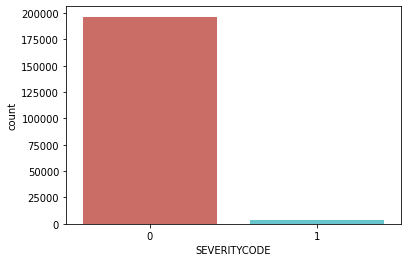

In [ ]:
sns.countplot(x='SEVERITYCODE', data=dc3,palette='hls')
plt.show()
#plt.savefig('count_plot')

#sns.countplot(dc3['SEVERITYCODE']);

In [ ]:
dc3.describe()
dc3.info()
#dc2.groupby('SEVERITYCODE').mean()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200081 entries, 0 to 221737
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   SEVERITYCODE  200081 non-null  object
 1   ADDRTYPE      200081 non-null  object
 2   JUNCTIONTYPE  200081 non-null  object
 3   UNDERINFL     200081 non-null  object
 4   WEATHER       200081 non-null  object
 5   ROADCOND      200081 non-null  object
 6   LIGHTCOND     200081 non-null  object
dtypes: object(7)
memory usage: 17.2+ MB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

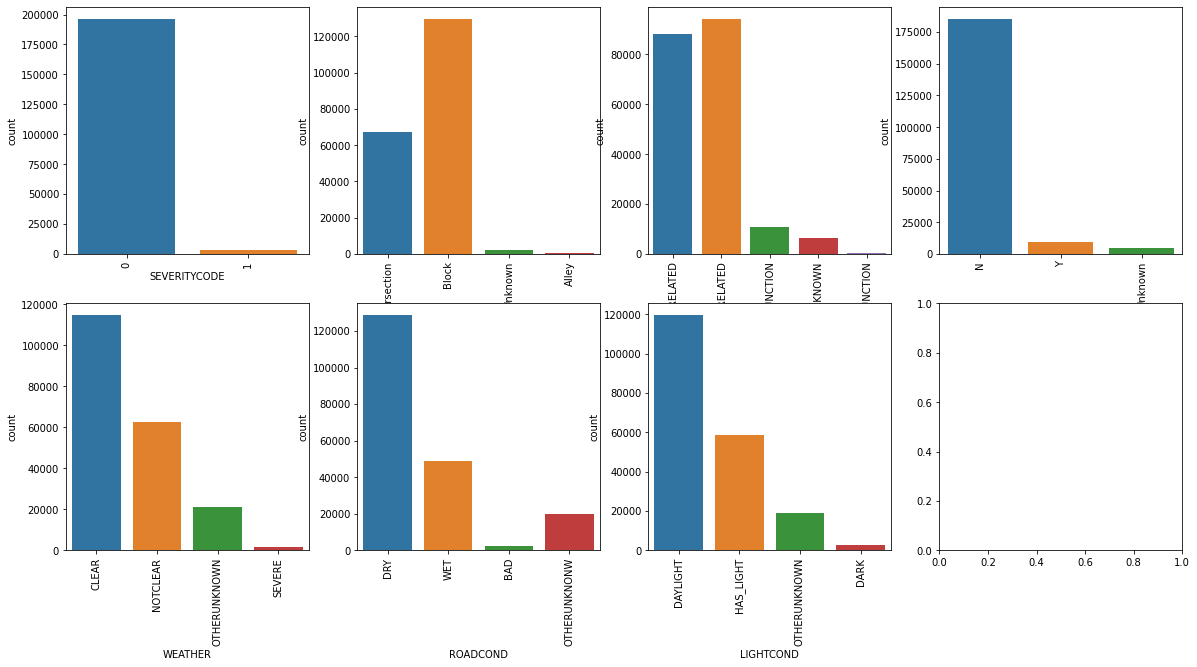

In [ ]:
categorical = ['SEVERITYCODE','ADDRTYPE','JUNCTIONTYPE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND']
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(dc3[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [ ]:
# show 6 variables distribution by severitycode


Text(0, 0.5, 'Proportion of incident severity')

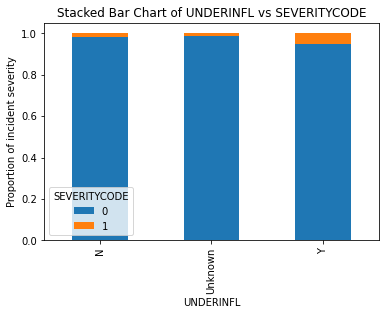

In [ ]:
table=pd.crosstab(dc3.UNDERINFL,dc3.SEVERITYCODE)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of UNDERINFL vs SEVERITYCODE')
plt.xlabel('UNDERINFL')
plt.ylabel('Proportion of incident severity')

Text(0, 0.5, 'Proportion of incident severity')

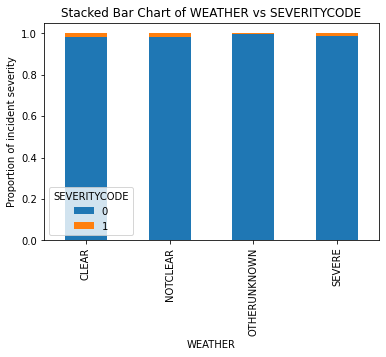

In [ ]:
table=pd.crosstab(dc3.WEATHER,dc3.SEVERITYCODE)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of WEATHER vs SEVERITYCODE')
plt.xlabel('WEATHER')
plt.ylabel('Proportion of incident severity')

Text(0, 0.5, 'Proportion of incident severity')

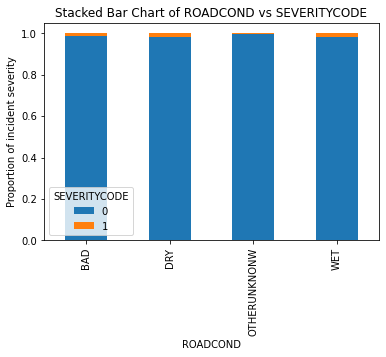

In [ ]:
table=pd.crosstab(dc3.ROADCOND,dc3.SEVERITYCODE)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of ROADCOND vs SEVERITYCODE')
plt.xlabel('ROADCOND')
plt.ylabel('Proportion of incident severity')

Text(0, 0.5, 'Proportion of incident severity')

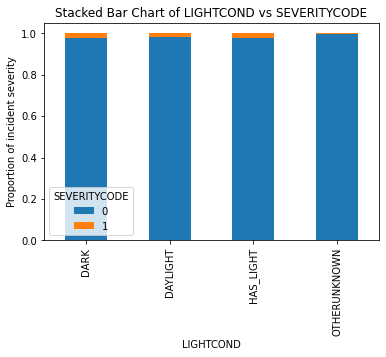

In [ ]:
table=pd.crosstab(dc3.LIGHTCOND,dc3.SEVERITYCODE)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of LIGHTCOND vs SEVERITYCODE')
plt.xlabel('LIGHTCOND')
plt.ylabel('Proportion of incident severity')

### UNDERINFL and SEVERITYCODE

In [ ]:
pd.crosstab(dc3.UNDERINFL,dc3.SEVERITYCODE )



SEVERITYCODE,0,1
UNDERINFL,,
N,182776,2900
Unknown,4718,58
Y,9124,505


In [ ]:
chi2_contingency(pd.crosstab(dc3.UNDERINFL,dc3.SEVERITYCODE ))

(737.6247810250065,
 6.711412661084219e-161,
 2,
 array([[1.82462322e+05, 3.21367840e+03],
        [4.69333704e+03, 8.26629615e+01],
        [9.46234136e+03, 1.66658638e+02]]))

In [ ]:
chi2_contingency(pd.crosstab(dc3.SEVERITYCODE,dc3.UNDERINFL))

(737.6247810250065,
 6.711412661084219e-161,
 2,
 array([[1.82462322e+05, 4.69333704e+03, 9.46234136e+03],
        [3.21367840e+03, 8.26629615e+01, 1.66658638e+02]]))

### WEATHER and SEVERITYCODE

In [ ]:
severity_weather_table = pd.crosstab(dc3.WEATHER, dc3.SEVERITYCODE)
severity_weather_table 

SEVERITYCODE,0,1
WEATHER,,
CLEAR,112557,2249
NOTCLEAR,61523,1079
OTHERUNKNOWN,20863,115
SEVERE,1675,20


In [ ]:
chi2_contingency(pd.crosstab(dc3.WEATHER, dc3.SEVERITYCODE))

(210.6770576754734,
 2.0789967972632254e-45,
 3,
 array([[1.12818939e+05, 1.98706113e+03],
        [6.15184852e+04, 1.08351481e+03],
        [2.06149130e+04, 3.63087020e+02],
        [1.66566296e+03, 2.93370435e+01]]))

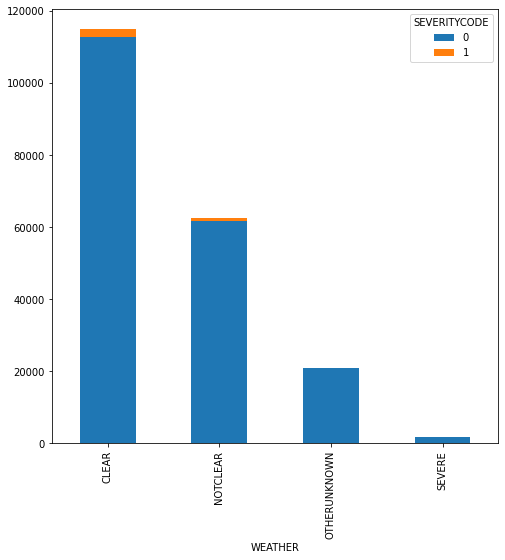

In [ ]:
severity_weather_table.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)


#severity_weather_table.div(table.sum(1).astype(float),axis=1).plot(kind="bar", 
#                 figsize=(8,8),
#                 stacked=True)

In [ ]:
#severity_weather_table.div(table.sum(1).astype(float))

### ROADCOND and SEVERITYCODE

In [ ]:
severity_roadcond_table = pd.crosstab(dc3.ROADCOND, dc3.SEVERITYCODE)
severity_roadcond_table 

SEVERITYCODE,0,1
ROADCOND,,
BAD,2296,27
DRY,126149,2511
OTHERUNKNONW,20087,94
WET,48086,831


In [ ]:
chi2_contingency(pd.crosstab(dc3.ROADCOND, dc3.SEVERITYCODE))

(231.48235485787444,
 6.611628720108943e-50,
 3,
 array([[2.28279354e+03, 4.02064614e+01],
        [1.26433154e+05, 2.22684603e+03],
        [1.98317074e+04, 3.49292552e+02],
        [4.80703450e+04, 8.46654960e+02]]))

### LIGHTCOND and SEVERITYCODE

In [ ]:
lightcond_roadcond_table = pd.crosstab(dc3.LIGHTCOND, dc3.SEVERITYCODE)
lightcond_roadcond_table 

SEVERITYCODE,0,1
LIGHTCOND,,
DARK,2785,58
DAYLIGHT,117597,1955
HAS_LIGHT,57478,1355
OTHERUNKNOWN,18758,95


In [ ]:
chi2_contingency(pd.crosstab(dc3.LIGHTCOND, dc3.SEVERITYCODE))

(288.17205756595337,
 3.6099241332012322e-62,
 3,
 array([[2.79379338e+03, 4.92066163e+01],
        [1.17482795e+05, 2.06920485e+03],
        [5.78147190e+04, 1.01828099e+03],
        [1.85266925e+04, 3.26307540e+02]]))

## Create Dummy Variables

In [ ]:
data_final = pd.get_dummies(dc3, columns=['ADDRTYPE','JUNCTIONTYPE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND'])
data_final.head()



,SEVERITYCODE,ADDRTYPE_Alley,ADDRTYPE_Block,ADDRTYPE_Intersection,ADDRTYPE_Unknown,JUNCTIONTYPE_DRIVEWAY_JUNCTION,JUNCTIONTYPE_INTERSECTION_RELATED,JUNCTIONTYPE_INTERSECTION_UNRELATED,JUNCTIONTYPE_OTHERUNKNOWN,JUNCTIONTYPE_RAMP_JUNCTION,UNDERINFL_N,UNDERINFL_Unknown,UNDERINFL_Y,WEATHER_CLEAR,WEATHER_NOTCLEAR,WEATHER_OTHERUNKNOWN,WEATHER_SEVERE,ROADCOND_BAD,ROADCOND_DRY,ROADCOND_OTHERUNKNONW,ROADCOND_WET,LIGHTCOND_DARK,LIGHTCOND_DAYLIGHT,LIGHTCOND_HAS_LIGHT,LIGHTCOND_OTHERUNKNOWN
0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0
1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0
2,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0
4,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [ ]:
dc3.head()

,SEVERITYCODE,ADDRTYPE,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND
0,0,Intersection,INTERSECTION_RELATED,N,CLEAR,DRY,DAYLIGHT
1,0,Block,INTERSECTION_UNRELATED,N,NOTCLEAR,WET,HAS_LIGHT
2,0,Block,INTERSECTION_UNRELATED,N,CLEAR,DRY,HAS_LIGHT
3,0,Intersection,INTERSECTION_RELATED,N,NOTCLEAR,WET,HAS_LIGHT
4,0,Block,INTERSECTION_UNRELATED,N,CLEAR,BAD,HAS_LIGHT


In [ ]:
# this didn't work

#from sklearn.preprocessing import OneHotEncoder

#oe_style = OneHotEncoder()
#oe_results = oe_style.fit_transform(dc3[['ADDRTYPE','JUNCTIONTYPE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND']])
#pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_).head()

In [ ]:
#data_final=data[to_keep]
#data_final.columns.values

In [ ]:
data_final.shape

(200081, 25)

In [ ]:
data_final.dtypes

SEVERITYCODE                           object
ADDRTYPE_Alley                          uint8
ADDRTYPE_Block                          uint8
ADDRTYPE_Intersection                   uint8
ADDRTYPE_Unknown                        uint8
JUNCTIONTYPE_DRIVEWAY_JUNCTION          uint8
JUNCTIONTYPE_INTERSECTION_RELATED       uint8
JUNCTIONTYPE_INTERSECTION_UNRELATED     uint8
JUNCTIONTYPE_OTHERUNKNOWN               uint8
JUNCTIONTYPE_RAMP_JUNCTION              uint8
UNDERINFL_N                             uint8
UNDERINFL_Unknown                       uint8
UNDERINFL_Y                             uint8
WEATHER_CLEAR                           uint8
WEATHER_NOTCLEAR                        uint8
WEATHER_OTHERUNKNOWN                    uint8
WEATHER_SEVERE                          uint8
ROADCOND_BAD                            uint8
ROADCOND_DRY                            uint8
ROADCOND_OTHERUNKNONW                   uint8
ROADCOND_WET                            uint8
LIGHTCOND_DARK                    

In [ ]:
data_final['SEVERITYCODE']=data_final['SEVERITYCODE'].astype('int')

In [ ]:
data_final.dtypes

SEVERITYCODE                           int64
ADDRTYPE_Alley                         uint8
ADDRTYPE_Block                         uint8
ADDRTYPE_Intersection                  uint8
ADDRTYPE_Unknown                       uint8
JUNCTIONTYPE_DRIVEWAY_JUNCTION         uint8
JUNCTIONTYPE_INTERSECTION_RELATED      uint8
JUNCTIONTYPE_INTERSECTION_UNRELATED    uint8
JUNCTIONTYPE_OTHERUNKNOWN              uint8
JUNCTIONTYPE_RAMP_JUNCTION             uint8
UNDERINFL_N                            uint8
UNDERINFL_Unknown                      uint8
UNDERINFL_Y                            uint8
WEATHER_CLEAR                          uint8
WEATHER_NOTCLEAR                       uint8
WEATHER_OTHERUNKNOWN                   uint8
WEATHER_SEVERE                         uint8
ROADCOND_BAD                           uint8
ROADCOND_DRY                           uint8
ROADCOND_OTHERUNKNONW                  uint8
ROADCOND_WET                           uint8
LIGHTCOND_DARK                         uint8
LIGHTCOND_

In [ ]:

# Oversample training data
# y_test is 30% of the total dataset (200031). ratio of 0/1 maintaining at the original level
# y_train 0/1 ratio is now 50/50 split after the oversample.

# At a high level, SMOTE:

   # Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
   # Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.


X = data_final.loc[:, data_final.columns != 'SEVERITYCODE']
y = data_final.loc[:, data_final.columns == 'SEVERITYCODE'] 
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns


os_data_X, os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

length of oversampled data is  275294
Number of no subscription in oversampled data 137647
Number of subscription 137647
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [ ]:
# check target freq distribution of the oversampled training data

y_test.head()
y_test.groupby("SEVERITYCODE")["SEVERITYCODE"].count()

NameError: ignored

## Recursive Feature Elimination

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [ ]:
# select significant variables using oversampled training data

data_final_vars=data_final.columns.values.tolist()
y=['SEVERITYCODE']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
rfe = RFE(logreg)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)


[False  True  True  True  True  True  True False False False  True False
 False False False False  True False  True False  True  True  True False]
[ 3  1  1  1  1  1  1 10 13  9  1  2  5  6 11 12  1  7  1  8  1  1  1  4]


In [ ]:
cols=['ADDRTYPE_Alley','ADDRTYPE_Block','ADDRTYPE_Intersection','ADDRTYPE_Unknown'\
      ,'JUNCTIONTYPE_DRIVEWAY_JUNCTION','JUNCTIONTYPE_INTERSECTION_RELATED'\
      ,'LIGHTCOND_DARK'\
      ,'ROADCOND_OTHERUNKNONW'\
      ,'UNDERINFL_N','UNDERINFL_Y'\
      ,'WEATHER_CLEAR','WEATHER_NOTCLEAR'] 
X=os_data_X[cols]
y=os_data_y['y']

What is the difference between

(statsmodels.api library)

logit_model.fit()

Is there a .predict method in the library?

---


(sklearn LogisticRegression) 


LogisticRegression.fit(X_train, y_train)



---
In this case, two approaches generated the same results





In [ ]:
# Build the model with significant variables

import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()  
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.659788
         Iterations 11
                                  Results: Logit
Model:                    Logit                 Pseudo R-squared:      0.048      
Dependent Variable:       y                     AIC:                   363295.2897
Date:                     2021-01-08 21:39      BIC:                   363421.5968
No. Observations:         275294                Log-Likelihood:        -1.8164e+05
Df Model:                 11                    LL-Null:               -1.9082e+05
Df Residuals:             275282                LLR p-value:           0.0000     
Converged:                1.0000                Scale:                 1.0000     
No. Iterations:           11.0000                                                 
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------

In [ ]:
cols=['ADDRTYPE_Alley','ADDRTYPE_Block','ADDRTYPE_Intersection','ADDRTYPE_Unknown'\
      ,'JUNCTIONTYPE_DRIVEWAY_JUNCTION','JUNCTIONTYPE_INTERSECTION_RELATED'\
     # ,'LIGHTCOND_DARK'\
      ,'ROADCOND_OTHERUNKNONW'\
      ,'UNDERINFL_N','UNDERINFL_Y'\
      ,'WEATHER_CLEAR','WEATHER_NOTCLEAR'] 
X=os_data_X[cols]
y=os_data_y['y']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.659788
         Iterations 11
                                  Results: Logit
Model:                    Logit                 Pseudo R-squared:      0.048      
Dependent Variable:       y                     AIC:                   363293.3022
Date:                     2021-01-08 21:42      BIC:                   363409.0837
No. Observations:         275294                Log-Likelihood:        -1.8164e+05
Df Model:                 10                    LL-Null:               -1.9082e+05
Df Residuals:             275283                LLR p-value:           0.0000     
Converged:                1.0000                Scale:                 1.0000     
No. Iterations:           11.0000                                                 
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------

This step does not seem needed. Can just directly predict the results using test dataset

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)  # should this be used instead? logreg.fit(X, y)

#logreg.score(X_test,y_test)
print(result.summary2())


                                  Results: Logit
Model:                    Logit                 Pseudo R-squared:      0.048      
Dependent Variable:       y                     AIC:                   363295.2897
Date:                     2021-01-08 21:04      BIC:                   363421.5968
No. Observations:         275294                Log-Likelihood:        -1.8164e+05
Df Model:                 11                    LL-Null:               -1.9082e+05
Df Residuals:             275282                LLR p-value:           0.0000     
Converged:                1.0000                Scale:                 1.0000     
No. Iterations:           11.0000                                                 
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------
ADDRTYPE_Alley                    -3.1

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.63


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[27027 14312]
 [16445 24805]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.65      0.64     41339
           1       0.63      0.60      0.62     41250

    accuracy                           0.63     82589
   macro avg       0.63      0.63      0.63     82589
weighted avg       0.63      0.63      0.63     82589



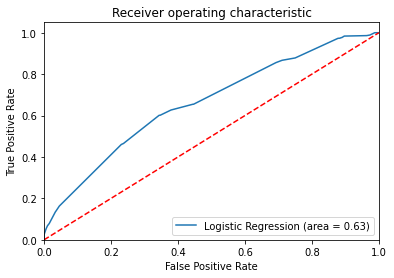

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Useful Syntax

In [ ]:
dc.head()

## drop variables

In [ ]:
dc2 = dc2.drop('PEDROWNOTGRNT', 1)

## replace value if condition

In [ ]:
dc2['ADDRTYPE']=dc2['ADDRTYPE'].replace(np.NaN,'Other')


#dc2.ADDRTYPE.replace(np.NaN,'Other', inplace=True)
#dc2['ADDRTYPE']=dc2.ADDRTYPE.apply(lambda x: x if not pd.isnull() else 'Other')


df.loc[df['column name'] condition, 'new column name'] = 'value if condition is met'
df['new column name'] = df['column name'].apply(lambda x: 'value if condition is met' if x condition else 'value if condition is not met')

#example
dc2.loc[dc2['UNDERINFL'] == 'N', 'UNDERINFL_NEW'] = 'N'
dc2.loc[dc2['UNDERINFL'] == 'Y', 'UNDERINFL_NEW'] = 'Y' 
dc2.loc[dc2['UNDERINFL'].isnull()== True, 'UNDERINFL_NEW'] = 'Other' 

## Scatterplot - Relationship between Categorical and Numerical data

In [ ]:
cond_plot = sns.FacetGrid(data=housing, col='Neighborhood', hue='CentralAir', col_wrap=4)
cond_plot.map(sns.scatterplot, 'OverallQual', 'SalesPrice');


## Scatterplot - Numerical Variables

In [ ]:
df = dat[['Income','Loan_amount','Investment','age','work_exp']]

sns.pairplot(df, kind="scatter")
plt.show()